[MIT License](https://github.com/cdslaborg/paramonte#license)  
[ParaMonte: plain powerful parallel Monte Carlo library](https://github.com/cdslaborg/paramonte).  
Copyright (C) 2012-present, [The Computational Data Science Lab](https://www.cdslab.org/#about)  
https://github.com/cdslaborg/paramonte  
[References](https://www.cdslab.org/paramonte/notes/overview/preface/#how-to-acknowledge-the-use-of-the-paramonte-library-in-your-work)  

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%matplotlib notebook
import paramonte as pm
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
sns.set()

paramonte 2.5.2
numpy 1.20.2
scipy 1.6.1
pandas 1.2.3
seaborn 0.11.1
matplotlib 3.4.1


## Simple power-law (or linear!) regression via the ParaDRAM sampler  

Supposed we have collected a dataset comprised of following $(x_i,y_i), \{i = 1, \ldots, 6\}$ pair observations,

\begin{eqnarray}
X &=& [0.5,~2.4,~3.2,~4.9,~6.5,~7.8], \\
Y &=& [0.8,~9.3,~37.9,~68.2,~155,~198].
\end{eqnarray}

and we would like to model the dependence of $Y$ on $X$. First thing to do in such problems is to **explore the data and visualize it** in search of any potential patterns, as we do below.

<IPython.core.display.Javascript object>


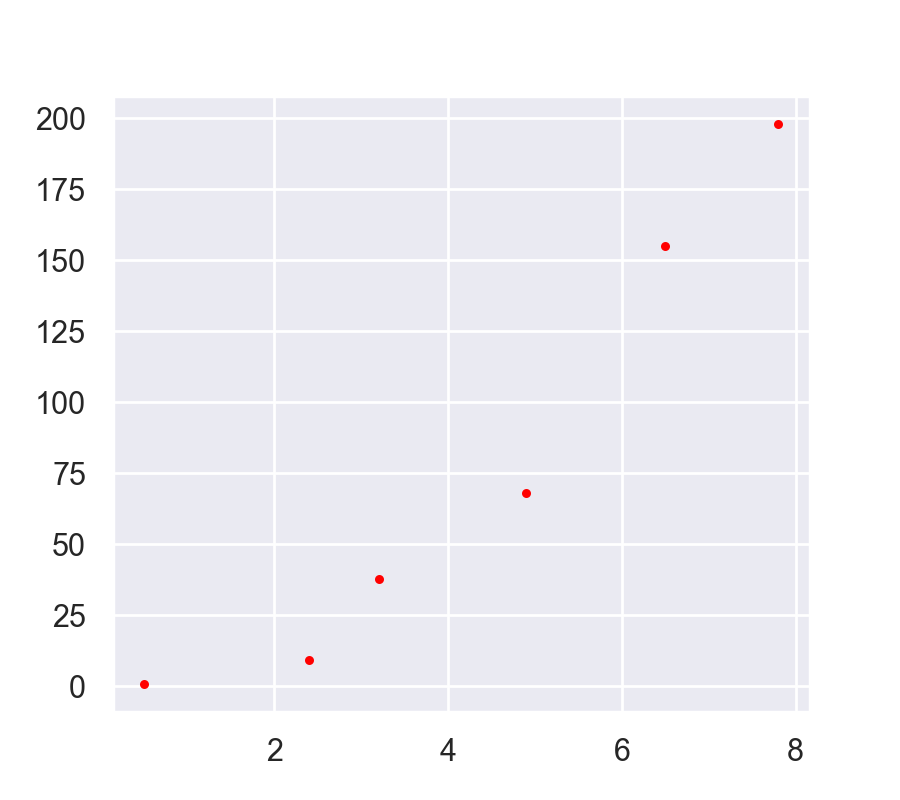

In [3]:
X = np.double([0.5, 2.4, 3.2, 4.9, 6.5, 7.8])
Y = np.double([0.8, 9.3, 37.9, 68.2, 155, 198])

fig = plt.figure  ( figsize = (4.5,4)
                  , dpi = 200
                  )
ax = fig.add_subplot(1,1,1)
ax.scatter( X
          , Y
          , color = "red" 
          , s = 5 # symbol size
          )

Obviously, the relationship between $X$ and $Y$ in this dataset is non-linear. A fairly experience Data Scientist could immediately guess the underlying relatioship in this dataset: **power-law**, which can be readily confirmed by checking the $X-Y$ relationship on a log-log plot. This works because if,  


$$
{\large y = \alpha x^\beta ~,}
$$
then, 
$$
{\large \log(y) = \log(\alpha) + \beta \log(x) ~.}
$$

<IPython.core.display.Javascript object>


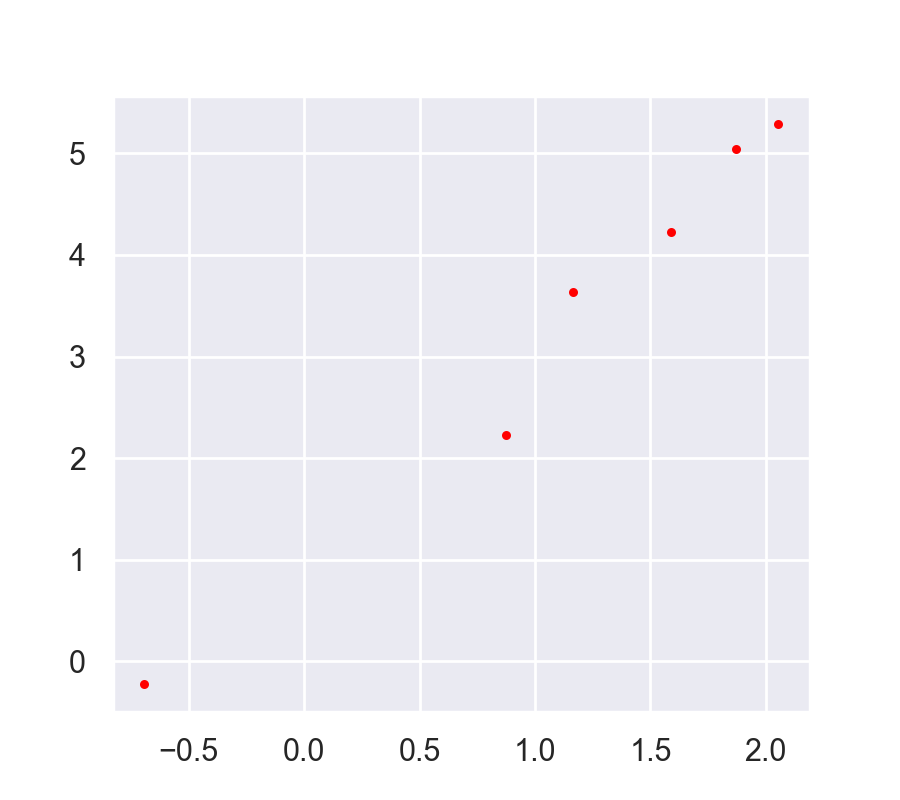

In [4]:
fig = plt.figure(figsize = (4.5,4), dpi = 200)
ax = fig.add_subplot(1,1,1)
ax.scatter(np.log(X), np.log(Y), color = "red", s = 5)

However, a simple line does not perfectly fit the (log-transformed) data either. Therefore, we must also take into account the **inherent variability** in our data around the linear fit. 

Although not always correct, the simplest most popular assumption about the noise in data is that the $Y$ is distributed according to a Normal distribution around the best-fit line to our log-transformed data,  

$$
{\large 
\pi(\log(y)|\log(x),\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\bigg[-\frac{1}{2}\bigg(\frac{\log(y)-\mu}{\sigma}\bigg)^2\bigg] 
} ~~,
$$

The unknown parameters of this Normal distribution, the mean ($\mu$) and the standard deviation ($\sigma$) would have to be then determined by fitting. Fortunately, the mean of the normal distribution can be simply taken to be the prediction of our best linear fit. Therefore, the mean is a function of the $x$ value and the slope and intercept of our linear fit to log-transformed data. However, the standard deviation would be to fit and constrained separately.

Now that we have constructed our model and the noise, we can proceed to use the principle of Maximum Likelihood to constrain the unknown parameters of the model using the Markov Chain Monte Carlo approach that is available from the ParaMonte library via the `ParaDRAM()` sampler class.  

To summarize, the unknown parameters are the slope and intercept of the linear fit and the standard deviation (`sigma`) of the Normal distribution.

The probability of observing a single data point is given by the above Normal Probability Density Function (PDF). Therefore, the probability of observing all of our dataset, assuming they are independent and identically distributed (i.i.d.), is simply the multiplication of all of the individual probabilities, 

\begin{eqnarray}
\large
\mathcal{L}(\log(Y),\log(X) ~|~ \text{intercept, slope, }\sigma) 
&=& 
\large
\prod_{i=1}^{N=6}~\pi(\log(y_i)|\log(x_i),\mu,\sigma) ~, \\
\large
\mu(\log(x),\text{intercept, slope, }\sigma) 
&=& 
\large
\text{intercept} + \text{slope} \times \log(x) ~,
\end{eqnarray}

The likelihood is often difficult as the likliehood value is often very tiny often causing underflow in computers. Therefore, we often prefer to work with the log-transformation of the likelihood which does not suffer from the same problem,  

\begin{eqnarray}
{\large
\log\mathcal{L}(\log(Y),\log(X) ~|~ \text{intercept, slope, }\sigma) = \sum_{i=1}^{N=6}~\log\pi(\log(y_i)|\log(x_i),\mu,\sigma) ~,
}
\end{eqnarray}


We now go on to implement this log-likelihood  as Python function. However, before doing so, we shall take care of an extremely important issue: **The possible range of values of the parameters**.  

If you pay attention to the parameters, you will notice that the intercept and slope can in general be any real value from negative infinity to positive infinity. However, the third parameter, the standard deviation parameter of the Normal distribution is a strictly positive-valued number. This range-asymmetry can cause instabilities in our Markov Chain sampler.

**How can we solve this and symmetrize the range of sigma?** The answer is simple: We will sample $\log(\sigma)$ instead of sigma itself ($\sigma$). So our third sampling parameter will be `logSigma` instead of `sigma`, which has a symmetric possible range from negative infinity to positive infinity. Then, inside our likelihood function, we will convert `logSigma` back to `sigma`.

In [12]:
from scipy.stats import norm

logX = np.log(X)
logY = np.log(Y)

def getLogLike(param):
    """
    Return the natural logarithm of the likelihood of observing the (X,Y) dataset defined 
    globally outside of this function given the input parameter vector ``param``.
    
    Parameters
    ==========
    
        param
            A numpy 64-bit real vector containing the parameters of the model in the following order:
            intercept, slope, log(sigma) (standard deviation of the Normal distribution).
    
    Returns
    =======
        logLike
            The natural logarithm of the likelihood of observing the dataset (X,Y) given ``param``.
    """
    
    # Compute the expected value of y, given each value of x. 
    # This is the mean of the Normal distribution given the x values.
    
    mean = param[0] + param[1] * logX
    
    # Compute the log-PDFs of oberserving each data point given the inpur parameters.
    
    logProbDensities = norm.logpdf(logY, loc = mean, scale = np.exp(param[2])) # Note that param[2] is logSigma.
    
    # Compute and return the log-likliehood
    
    return np.sum(logProbDensities)

Now let's test this likliehood function for a random input test value for the parameters to ensure it works fine. We will pick our best guess (simply by visual inspection of the data log-log plot).

In [13]:
getLogLike(param = np.double([0.8,2,0.1]))

-6.501444916760644

We can now proceed to the set up a ParaDRAM Markov Chain Monte Carlo sampler to constrain the three unknown parameters of the model.

In [14]:
import paramonte as pm
pmpd = pm.ParaDRAM() # instantiate an object of class ParaDRAM sampler Paradram() or paradram() would also work.

The following settings are optional but recommended.

In [15]:
pmpd.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
pmpd.spec.outputFileName = "./out/regression_powerlaw" # specify the output file prefixes.
pmpd.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
pmpd.spec.variableNameList = ["intercept", "slope", "logSigma"] # set the output names of the parameters.
pmpd.spec.chainSize = 20000 # set the number of uniquely sampled points from the likelihood function.

Since we did not set the sarting point of the MCMC sampler, the default (origin) will be used as the starting point of our seach, which is not too bad. Finally, we run the sampler,

In [16]:
pmpd.runSampler( ndim = 3 # the number of parameters
               , getLogFunc = getLogLike # the objective function to sample points from.
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readReport()      # to read the summary report from the output report file.
ParaDRAM - NOTE:     pmpd.readSample()      # to read the final i.i.d. sample from the output sample file.
ParaDRAM - NOTE:     pmpd.readChain()       # to read the uniquely-accepted points from the output chain file.
ParaDRAM - NOTE:     pmpd.readMarkovChain() # to read the Markov Chain. NOT recommended for very large chains.
ParaDRAM - NOTE:     pmpd.readRestart()     # to read the contents of an ASCII-format output restart file.
ParaDRAM 

Done. We can read the generated sample to analyze and visualize the results. However, before doing so, we will make sure there is no lack of convergence in the MCMC chain by inspecting the **adapation measure** of the chain that is available in the output chain file.

In [17]:
chain = pmpd.readChain(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/regression_powerlaw*_chain.txt"


ParaDRAM - NOTE: processing chain file: D:\Dropbox\Projects\20180101_ParaMonte\git\paramontex\Python\Jupyter\regression_powerlaw_lognormal_data_paradram\out\regression_powerlaw_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.050026 seconds.
ParaDRAM - NOTE: ndim = 3, count = 20000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools..

ParaDRAM - NOTE: making the scatter plot... 

<IPython.core.display.Javascript object>


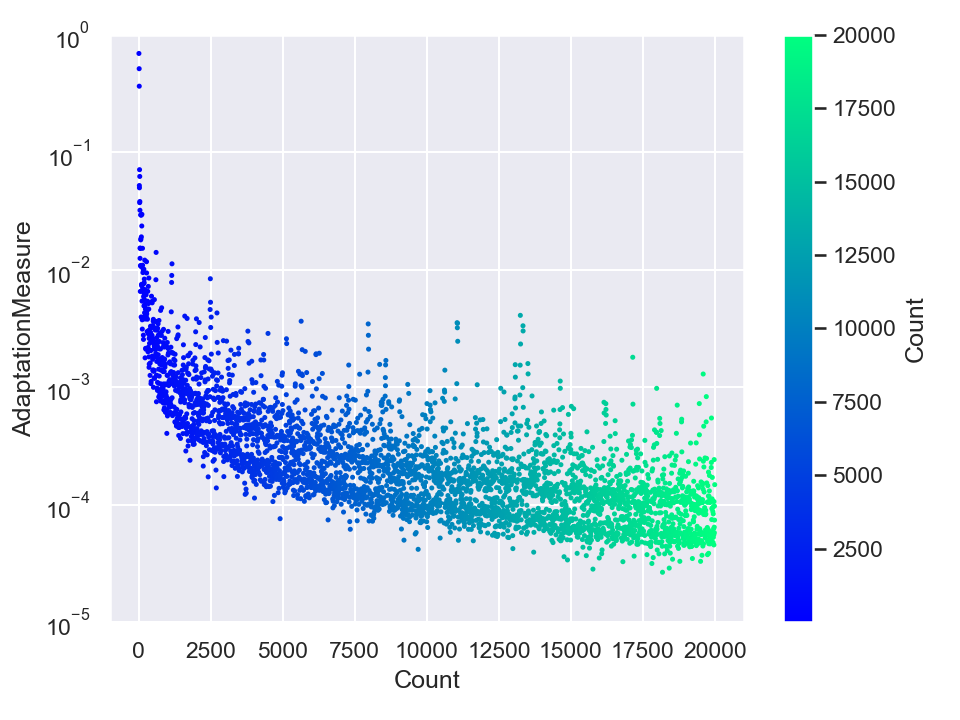

done in 0.150441 seconds.


In [18]:
chain.plot.scatter.scatter.kws.cmap = "winter" # change the color-mapping from the default "autumn"
chain.plot.scatter( ycolumns = "AdaptationMeasure" # choose the AdaptationMeasure column of the output chain file to plot
                  , ccolumns = [] # set the color of the points to empty from the default logLikelihood value.
                  )
chain.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])
chain.plot.scatter.currentFig.axes.set_yscale("log")

The power-law decay of the adaptation measure tells us everything has gone well with our simulation. If there any signs of a lack of convergence, we would have not seen this power-law decaying behavior. This power-law decay implies that the proposal adaptation decayed and diminished consistently throughout the entire simulation, as we wished.

We can now visualize the resulting refined sample by reading and plotting it from the output sample file.

In [19]:
sample = pmpd.readSample(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/regression_powerlaw*_sample.txt"


ParaDRAM - NOTE: processing sample file: D:\Dropbox\Projects\20180101_ParaMonte\git\paramontex\Python\Jupyter\regression_powerlaw_lognormal_data_paradram\out\regression_powerlaw_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.02004 seconds.
ParaDRAM - NOTE: ndim = 3, count = 3556
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tool

ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


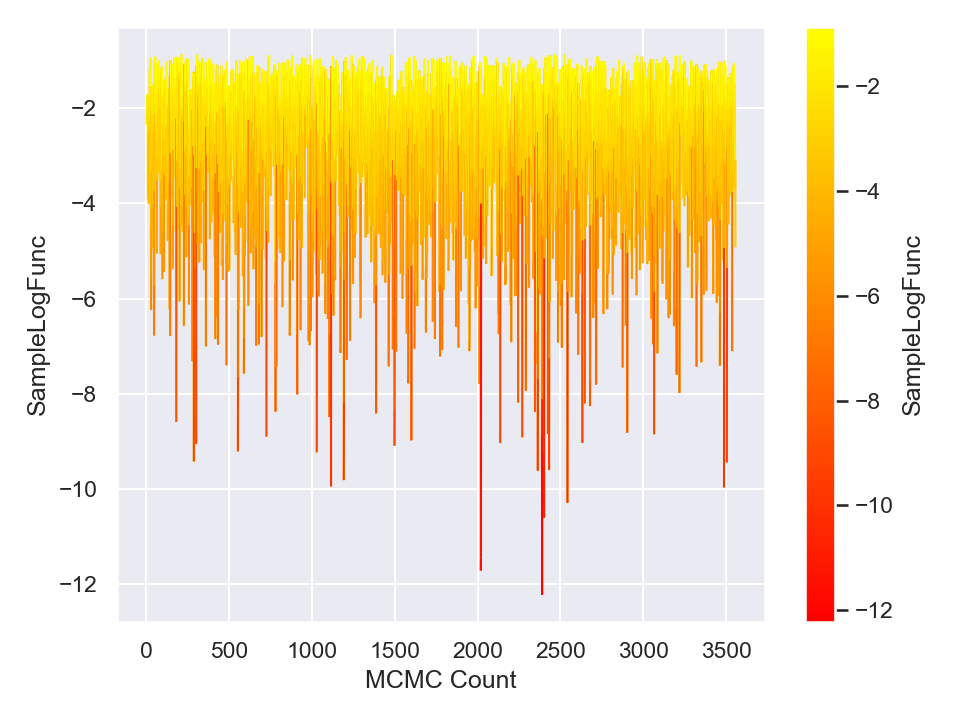

done in 0.160028 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_SampleLogFunc"
ParaDRAM - NOTE: done in 0.134692 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


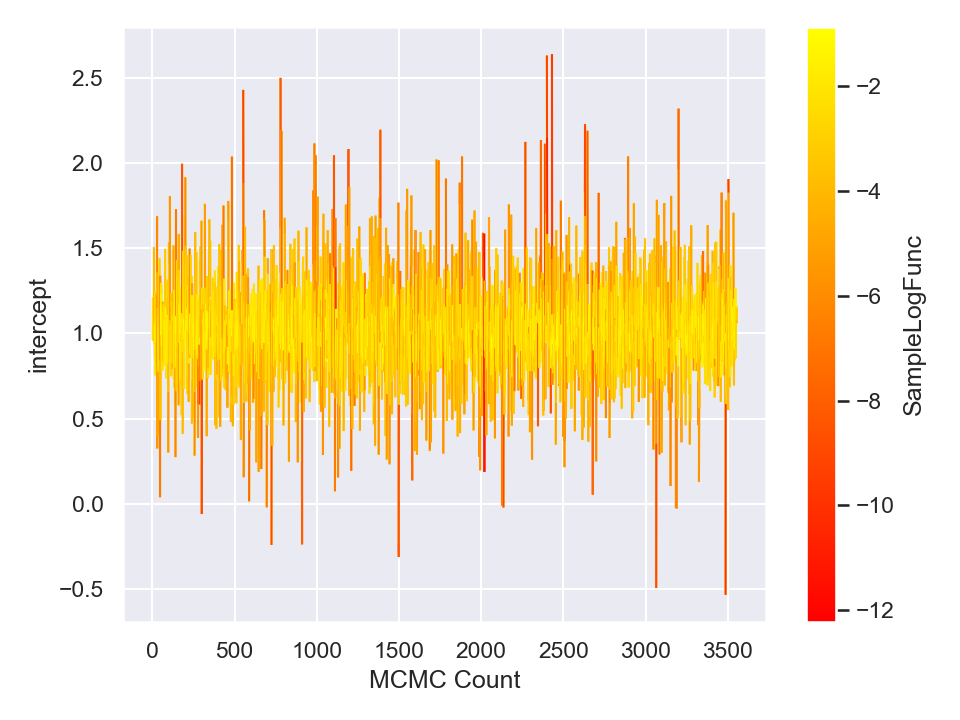

done in 0.190261 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_intercept"
ParaDRAM - NOTE: done in 0.130442 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


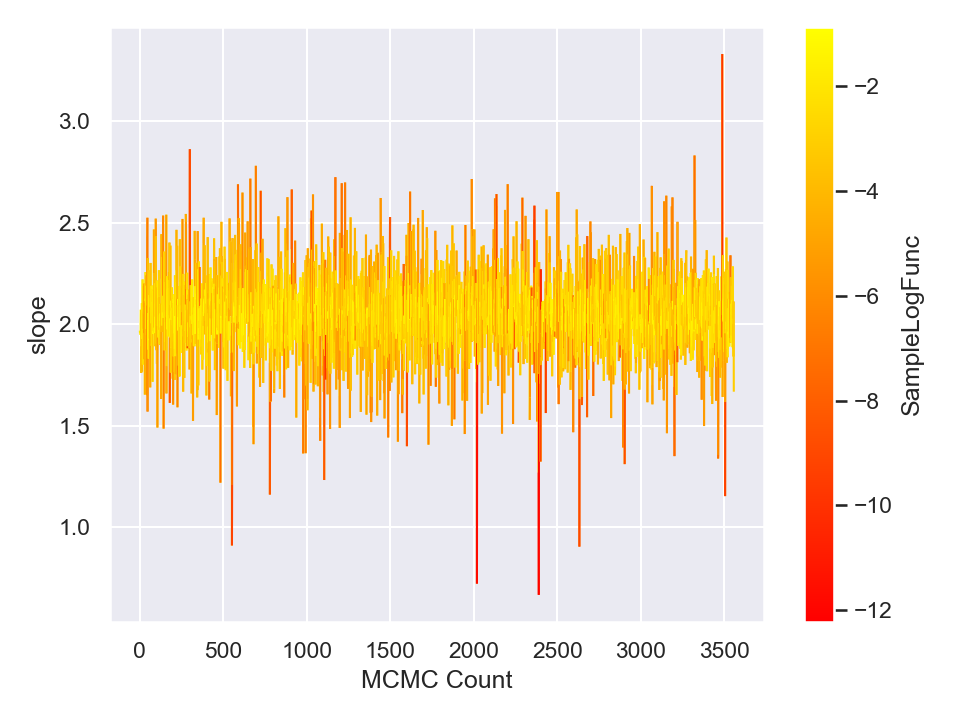

done in 0.164946 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_slope"
ParaDRAM - NOTE: done in 0.129863 seconds.
ParaDRAM - NOTE: making the line plot... 

<IPython.core.display.Javascript object>


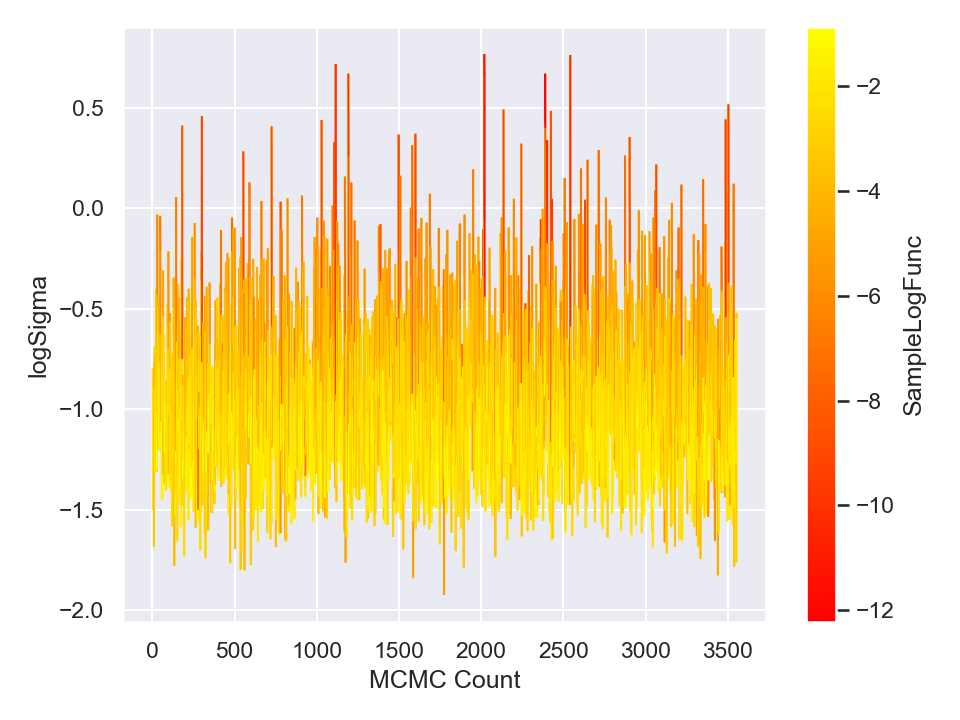

done in 0.225151 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/traceplot_logSigma"
ParaDRAM - NOTE: done in 0.154549 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


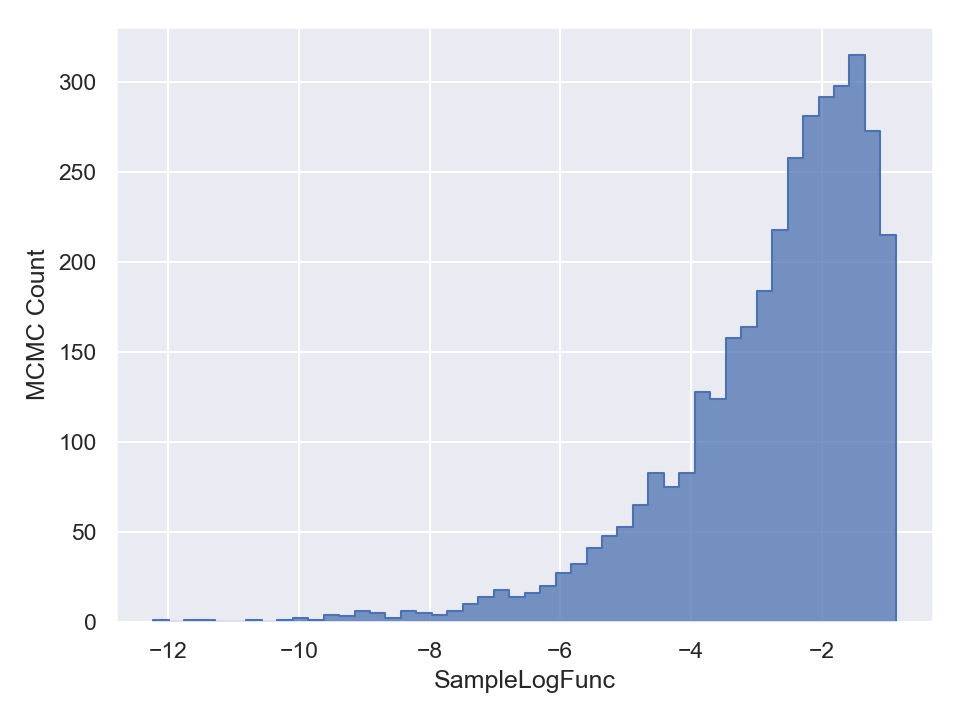

done in 0.099152 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_SampleLogFunc"
ParaDRAM - NOTE: done in 0.075154 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


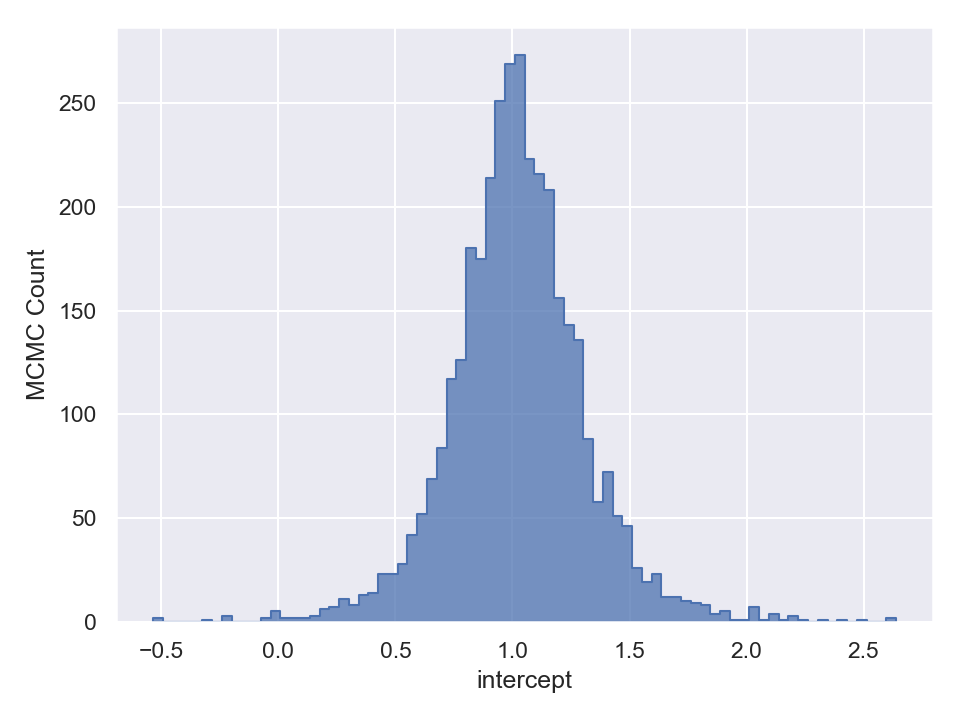

done in 0.104952 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_intercept"
ParaDRAM - NOTE: done in 0.075176 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


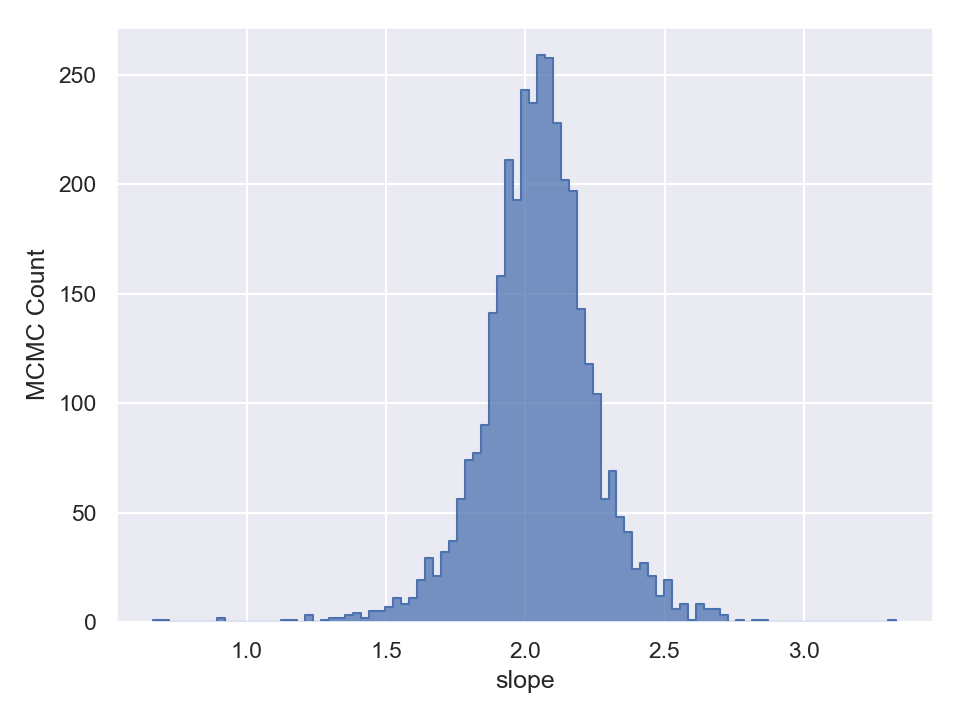

done in 0.099666 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_slope"
ParaDRAM - NOTE: done in 0.350332 seconds.
ParaDRAM - NOTE: making the histplot plot... 

<IPython.core.display.Javascript object>


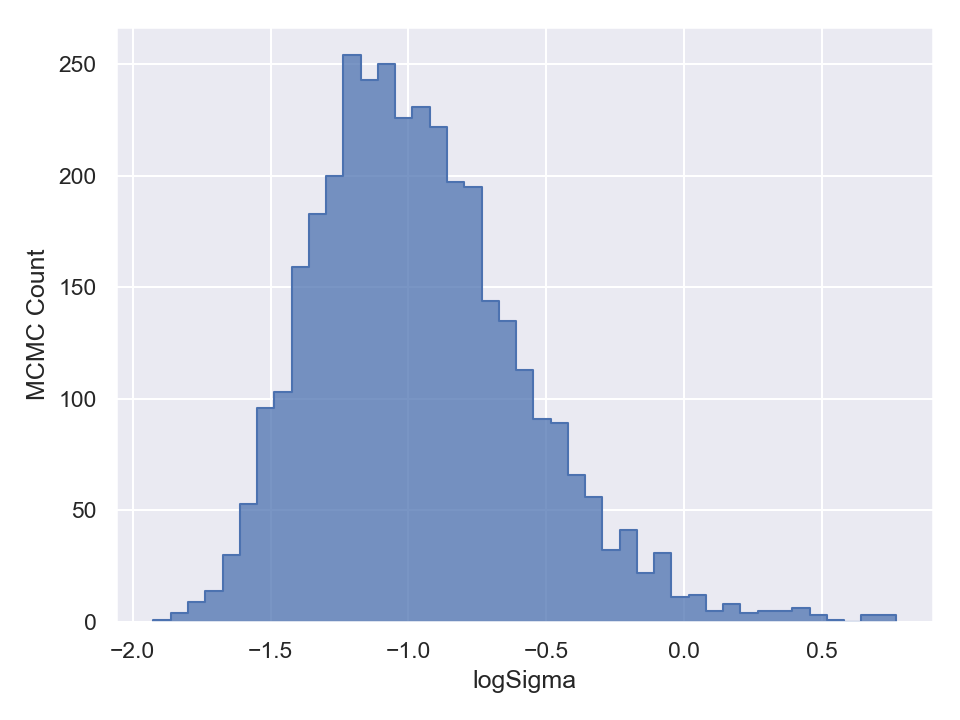

done in 0.099793 seconds.
ParaDRAM - NOTE: saving the plot to file: "./out/histogram_logSigma"
ParaDRAM - NOTE: done in 0.074801 seconds.


In [20]:
# plot the sampled variables

for colname in sample.df.columns:
    sample.plot.line.ycolumns = colname
    sample.plot.line()
    sample.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample.plot.line.currentFig.axes.set_ylabel(colname)
    sample.plot.line.savefig( fname = "./out/traceplot_" + colname )

# plot the histograms of the sampled parameters

for colname in sample.df.columns:
    sample.plot.histplot(xcolumns = colname)
    sample.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
    sample.plot.histplot.savefig( fname = "./out/histogram_" + colname )

Finally, lets take a look at the mean inferred values of the parameters.

In [21]:
sample.df.mean()

SampleLogFunc   -2.774132
intercept        1.023726
slope            2.047555
logSigma        -0.956525
dtype: float64

In [22]:
sample.df.std()

SampleLogFunc    1.538208
intercept        0.291519
slope            0.198676
logSigma         0.382014
dtype: float64

Our initial guess for the parameter values was not too far from the best-fit values! As for the value of sigma, all we need to do is to exponentiate the mean value of `logSgima`.

In [23]:
sigma = np.exp(sample.df.mean()[-1])
print("sigma = {}".format(sigma))

sigma = 0.38422566805608227


Now, lets make a grid plot of all of the parameters sampled together,

ParaDRAM - NOTE: making the grid plot... 


<IPython.core.display.Javascript object>


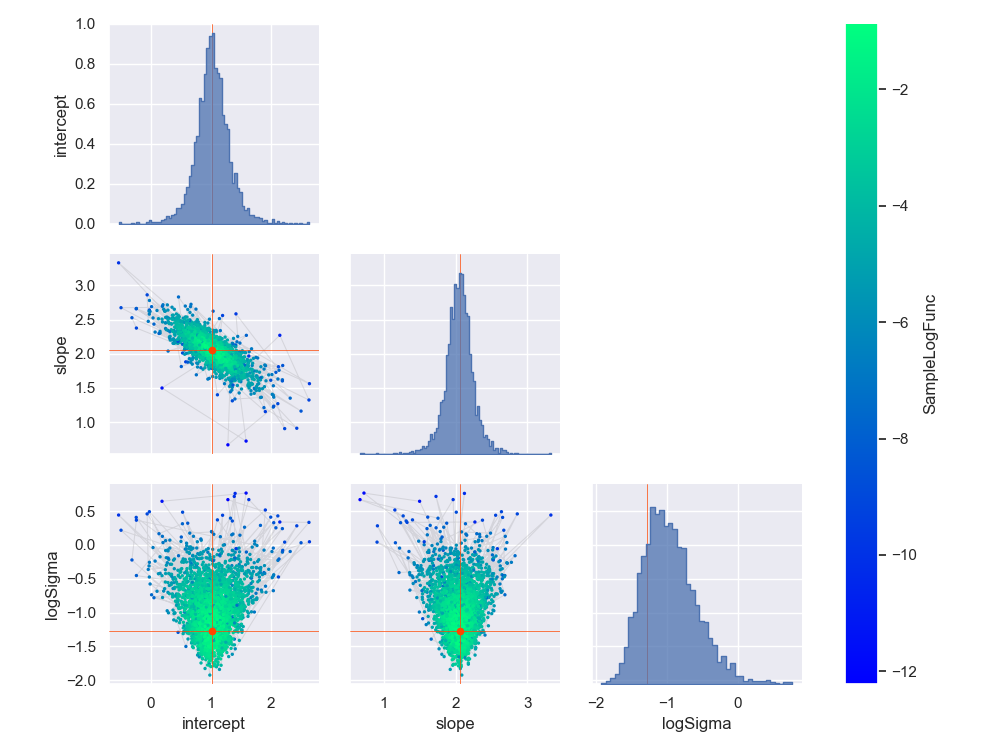

generating subplot #1: (0,0) out of 9... done in 0.043477 seconds.
generating subplot #2: (0,1) out of 9... done in 0.0 seconds.
generating subplot #3: (0,2) out of 9... done in 0.0 seconds.
generating subplot #4: (1,0) out of 9... done in 0.104789 seconds.
generating subplot #5: (1,1) out of 9... done in 0.043477 seconds.
generating subplot #6: (1,2) out of 9... done in 0.0 seconds.
generating subplot #7: (2,0) out of 9... done in 0.108066 seconds.
generating subplot #8: (2,1) out of 9... done in 0.099912 seconds.
generating subplot #9: (2,2) out of 9... done in 0.043477 seconds.
generating colorbar... done in 0.020206 seconds.
generating target #0: (0,0) out of 9... done in 0.010025 seconds.
generating target #0: (0,1) out of 9... done in 0.0 seconds.
generating target #0: (0,2) out of 9... done in 0.0 seconds.
generating target #0: (1,0) out of 9... done in 0.0 seconds.
generating target #0: (1,1) out of 9... done in 0.009921 seconds.
generating target #0: (1,2) out of 9... done in 

In [24]:
sample.plot.grid.plotType.upper.enabled = False # disable upper triangle
sample.plot.grid.plotType.lower.value = "lineScatter" # let lower triangle be lineScatter plot
sample.plot.grid(columns = [1,2,3]) # make grid plot of all parameters
sample.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plot

Now, let's visualize the best-fit line and its associated uncertainties.

In [25]:
sample.df

,SampleLogFunc,intercept,slope,logSigma
0,-2.331269,0.960854,1.967203,-0.794671
1,-2.331269,0.960854,1.967203,-0.794671
2,-2.034849,1.210047,1.953220,-1.499436
3,-2.034849,1.210047,1.953220,-1.499436
4,-1.725815,1.183755,1.947625,-0.898540
...,...,...,...,...
3551,-3.121256,1.064014,1.999731,-1.763329
3552,-1.949853,1.158996,1.876726,-1.270965
3553,-3.705440,1.060260,1.840250,-0.521335
3554,-3.102065,1.077597,2.110786,-0.546094


<IPython.core.display.Javascript object>


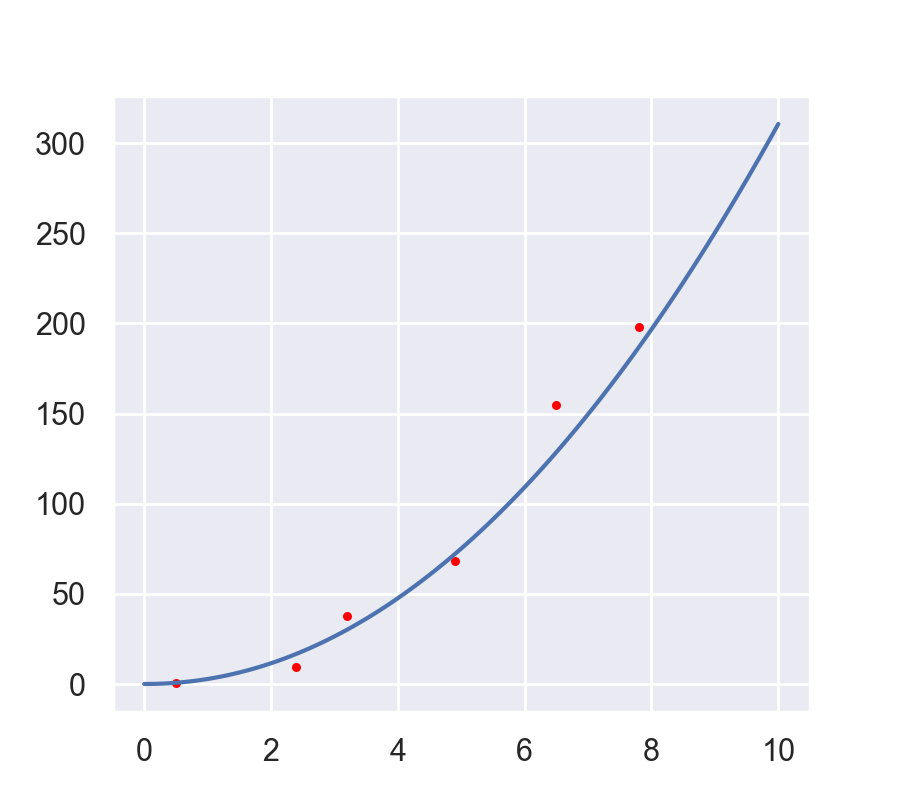

In [26]:
xvalues = np.linspace(0,10,101)
yvalues = np.exp(sample.df["intercept"].mean()) * xvalues ** sample.df["slope"].mean()

fig = plt.figure(figsize = (4.5,4), dpi = 200)
ax = fig.add_subplot(1,1,1)

ax.plot(xvalues, yvalues, "b")
ax.scatter(X, Y, color = "red", s = 5)

This many be already enough for many. But the joy of MCMC is in **uncertainty quantification** and the ability to visualize the uncertainty in our knowledge. This example is no exception. 

What we have shown above is just the expected best-fit line to our data. But corresponding to each sampled parameter set in the output sample file, there exists a **possible regression line** although each with a different probability of being correct. We can visualize all of them together to understand the state of uncertainty in our best-fit regression.

<IPython.core.display.Javascript object>


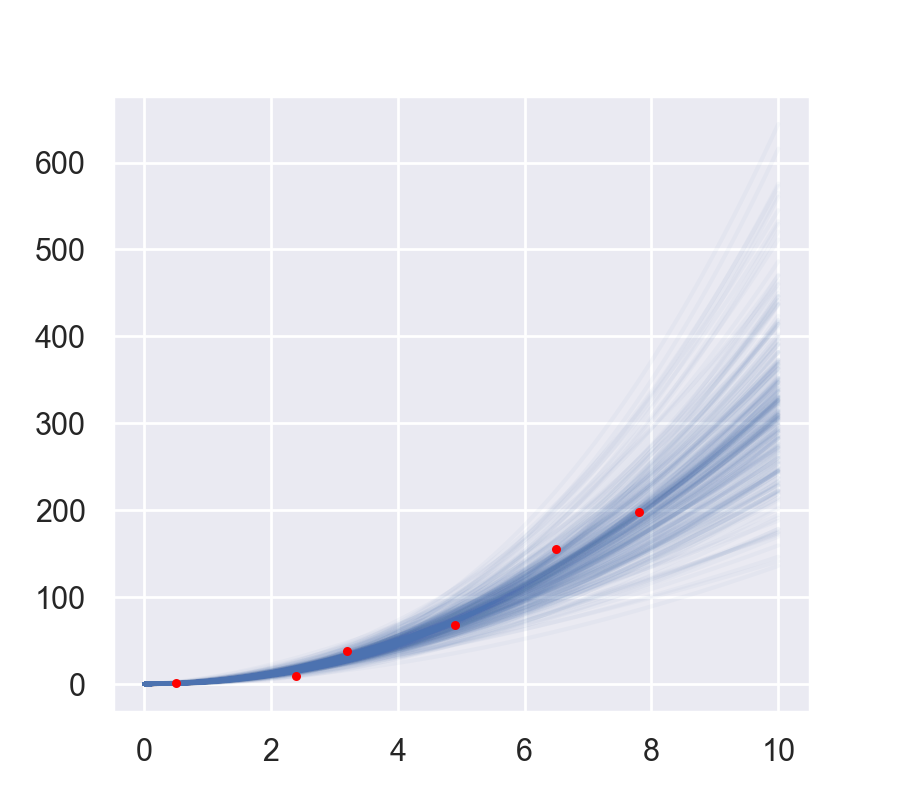

In [27]:
xvalues = np.linspace(0,10,101)

fig = plt.figure(figsize = (4.5,4), dpi = 200)
ax = fig.add_subplot(1,1,1)

# pick only a subset of sampled parameters

first = 0
last = 300
slopes = sample.df["slope"].values[first:last]
intercepts = sample.df["intercept"].values[first:last]

for slope, intercept in zip(slopes, intercepts):
    yvalues = np.exp(intercept) * xvalues ** slope
    ax.plot( xvalues
           , yvalues
           , "b" # color
           , alpha = 0.04 # transparency
           )

ax.scatter( X, Y
          , color = "red"
          , s = 5
          , zorder = 100000
          )

>**There are many more functionalities and features of the ParaMonte library that were neither explored nor mentioned in this example Jupyter notebook. You can explore them by checking the existing components of each attribute of the ParaDRAM sampler class and by visiting the [ParaMonte library's documentation website](http://cdslab.org/paramonte/)**.